### My approach is as follows: 1) Conducting grid-search for ARIMA(p, d, q) hyperparameters with seed obtained from inspecting ACP and PACP; 2) Building Holt's exponential smoothing with optimization; 3) Stacking the models by averaging; 4) Forecasting the quantities with 80%-confidence interval

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import psycopg2
import config
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from clickhouse_driver import Client
from clickhouse_driver import connect
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [3]:
# Loading data

client = Client(host='82.148.25.91', port='9000', database='test', user='ro_test', password='qwerty')

df = client.execute("select date, quantity, on_stock\
                     from ( select date, sum(start_day + finish_day) as on_stock\
                            from test.stocks_on_days\
                            where item_id='7d185936-7a60-11eb-ba7f-4a6a34607ded' and (start_day + finish_day) <> 0\
                            group by date\
                            order by date ) as l\
                     join\
                          ( select date, sum(quantity) as quantity\
                            from test.sales\
                            where item_id='7d185936-7a60-11eb-ba7f-4a6a34607ded'\
                            group by date\
                            order by date ) as p\
                     on l.date = p.date")
df = pd.DataFrame(df)
df.rename(columns={0:'dates', 1:'quantities', 2:'on_stock'}, inplace=True)

In [4]:
# Checking whether there are extreme cases 

mask = df['on_stock'] - df['quantities'] <= 0
df[mask]

,dates,quantities,on_stock
21,2021-01-25,49,48
26,2021-01-30,92,86


In [5]:
# Dropping the cases

df.drop([21, 26], inplace=True)
df.reset_index(drop=True, inplace=True)

In [6]:
# Extracting time series

ts = df['quantities']
ts.index = df['dates']

<AxesSubplot:xlabel='dates', ylabel='quantities'>

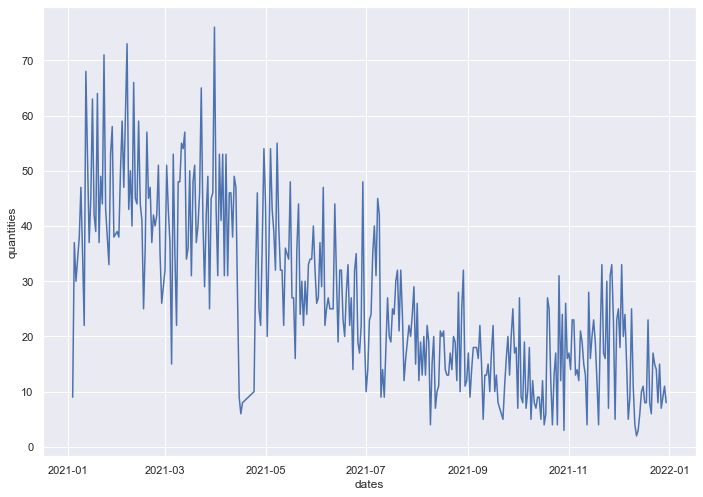

In [7]:
# Plotting the time series

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme(style="darkgrid")
sns.lineplot(data=ts)

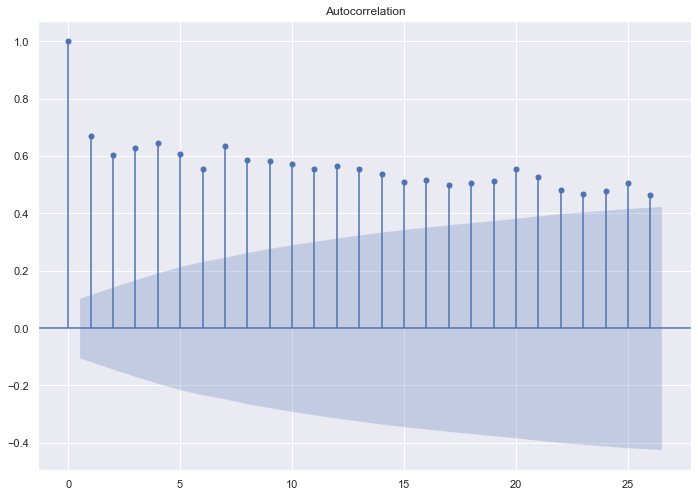

In [8]:
# Autocorrelations

p = plot_acf(ts.values)

In [9]:
# Using ADF to test null-hypothesis of non-sationarity 

filterr = adfuller(ts)
p_value = filterr[1]
print(p_value)

0.4829813192832663


### From the above we find the presence of a trend (ts plot, P-value >> 0.05). Hence the time series is not stationary and we need to differenciate it

In [10]:
ts_differenced = df['quantities'].diff()
ts_differenced.dropna(inplace=True)

Text(0.5, 0, 'Lag')

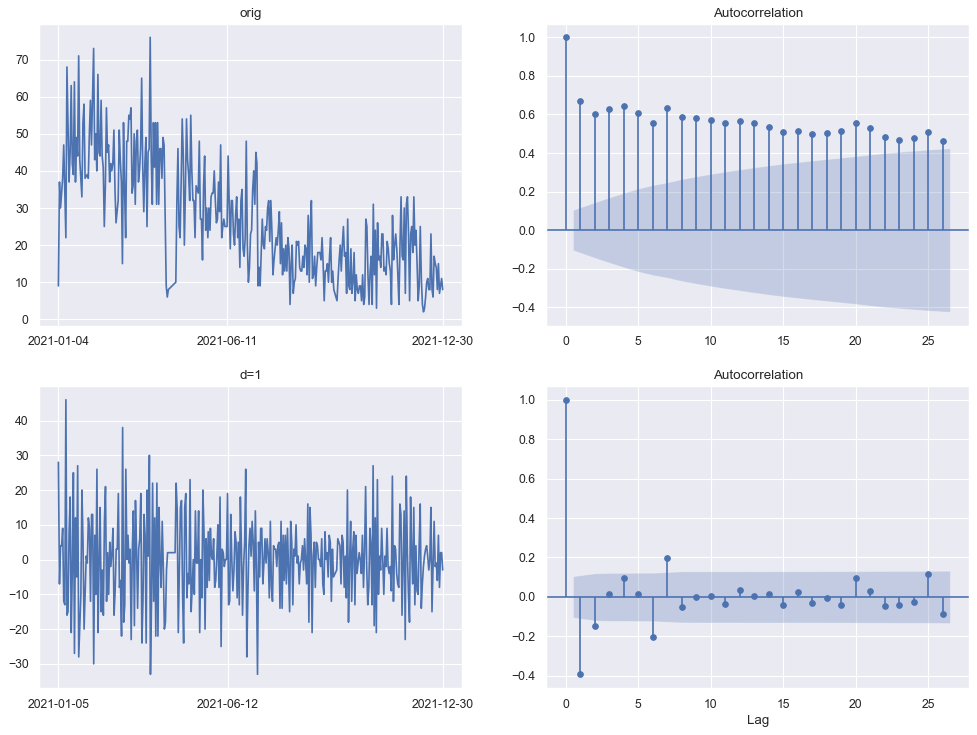

In [11]:
plt.rcParams.update({'figure.figsize':(15,11), 'figure.dpi':80})

# orig
fig, axes = plt.subplots(2, 2, sharex=False)
axes[0, 0].plot(ts)
axes[0, 0].set_title('orig')
axes[0, 0].set_xticks([ts.index[0], ts.index[150], ts.index[-1]], minor=False)
p1 = plot_acf(ts.values, ax=axes[0, 1])

# d=1
axes[1, 0].plot(ts_differenced)
axes[1, 0].set_title('d=1')
axes[1, 0].set_xticks([ts_differenced.index[0], ts_differenced.index[150], ts_differenced.index[-1]], minor=False)
p2 = plot_acf(ts_differenced.values, ax=axes[1, 1])
axes[1, 1].set_xlabel('Lag')

In [12]:
# Using ADF to test null-hypothesis of non-sationarity after the 1st differencing

filterr = adfuller(ts_differenced)
p_value = filterr[1]
print(p_value)

2.842854867052532e-19


### From the above we can see that the series reaches stationarity with the 1st order differencing (P-value << 0.5, autocorrelations quickly decay). Next we try to fit the appropriate ARIMA(p, 1, q) model by grid-search. For that we need to seed the initial values. We do it by inspecting Autocorrelation and Partial Autocorrelation plots.

Text(0.5, 0, 'Lag')

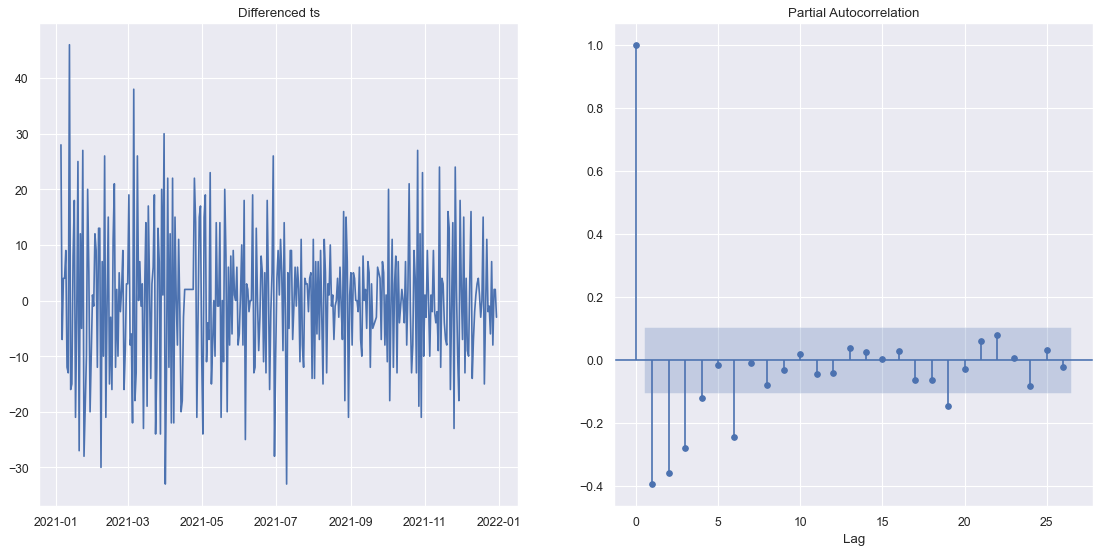

In [13]:
# Finding the order of AR(p) term by Partial Autocorrelation plot

plt.rcParams.update({'figure.figsize':(17,8), 'figure.dpi':80})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(ts_differenced)
axes[0].set_title('Differenced ts')
x = plot_pacf(ts_differenced, ax=axes[1])
axes[1].set_xlabel('Lag')

### From the above we can see that the appropriate p is in the set {0, 1, 2, 3, 4} since the fluctuation at lag = 19 (which is about 5%-significant) doesn't reject the null hypothesis of stationarity 

Text(0.5, 0, 'Lag')

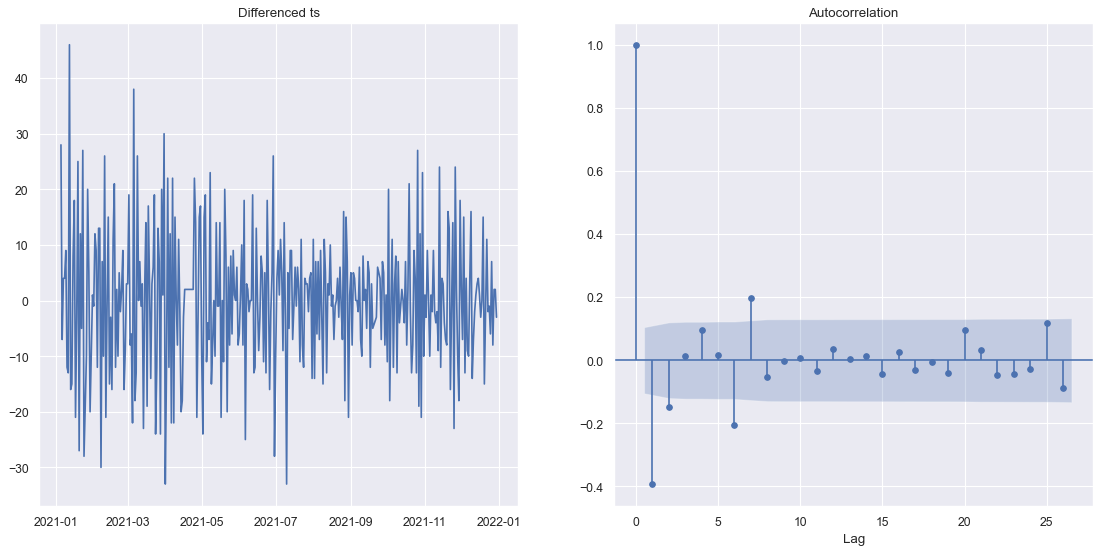

In [14]:
# Finding the order of MA(q) term by Autocorrelation plot

plt.rcParams.update({'figure.figsize':(17,8), 'figure.dpi':80})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(ts_differenced)
axes[0].set_title('Differenced ts')
x = plot_acf(ts_differenced.values, ax=axes[1])
axes[1].set_xlabel('Lag')

### From the above we guess q from the set {0, 1, 2, 3, 4, 5, 6}

In [15]:
# Trying ARIMA(2, 1, 4)

ts_training = pd.Series([float(x) for x in ts.values], index=ts.index, name='quantities')

model = ARIMA(np.array(ts_training), order=(2, 1, 4))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  350
Model:                 ARIMA(2, 1, 4)   Log Likelihood               -1294.458
Method:                       css-mle   S.D. of innovations              9.748
Date:                Wed, 16 Feb 2022   AIC                           2604.916
Time:                        11:50:08   BIC                           2635.779
Sample:                             1   HQIC                          2617.200
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0818      0.061     -1.336      0.182      -0.202       0.038
ar.L1.D.y     -0.7680      0.114     -6.761      0.000      -0.991      -0.545
ar.L2.D.y     -0.7794      0.138     -5.655      0.0

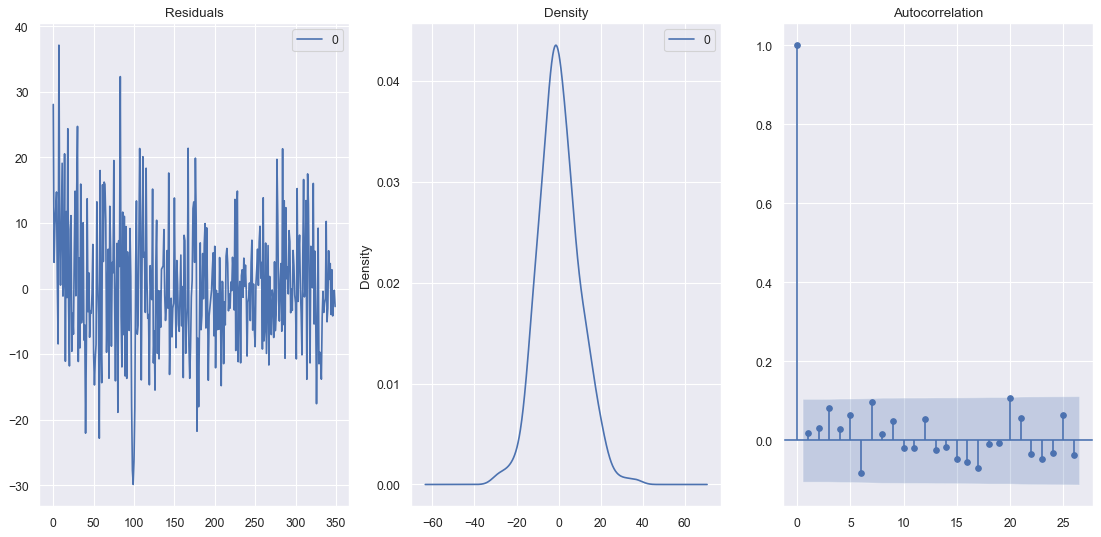

In [16]:
# Plotting residual errors, their density function and Autocorrelation plot

residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,3)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
p = plot_acf(residuals.values, ax=ax[2])

### We see that ARIMA(2, 1, 4) is pretty good in terms of residuals (with 95% confidence the residuals are generated by a purely random process)

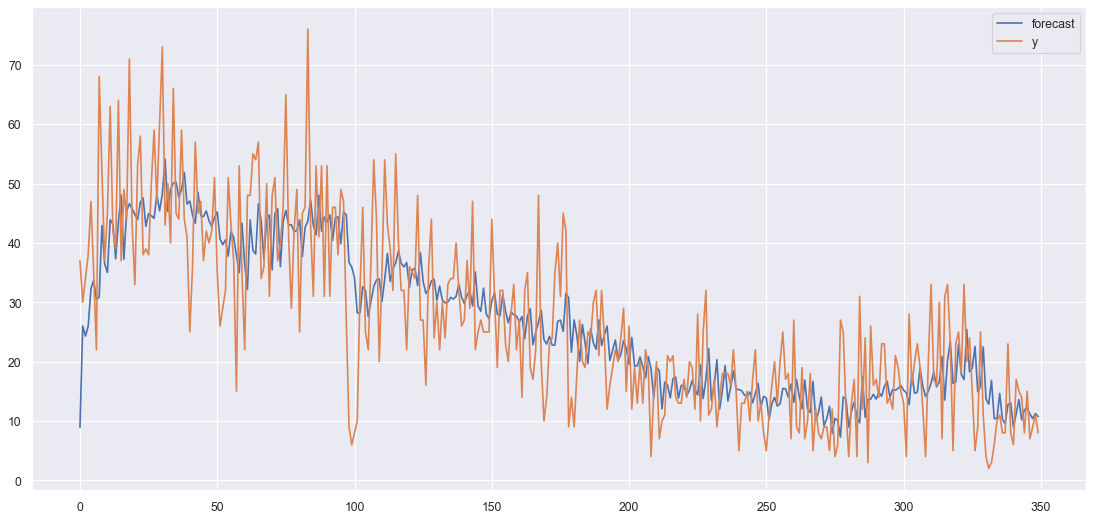

In [17]:
# Plotting the fitted values 

x = model_fit.plot_predict(dynamic=False)

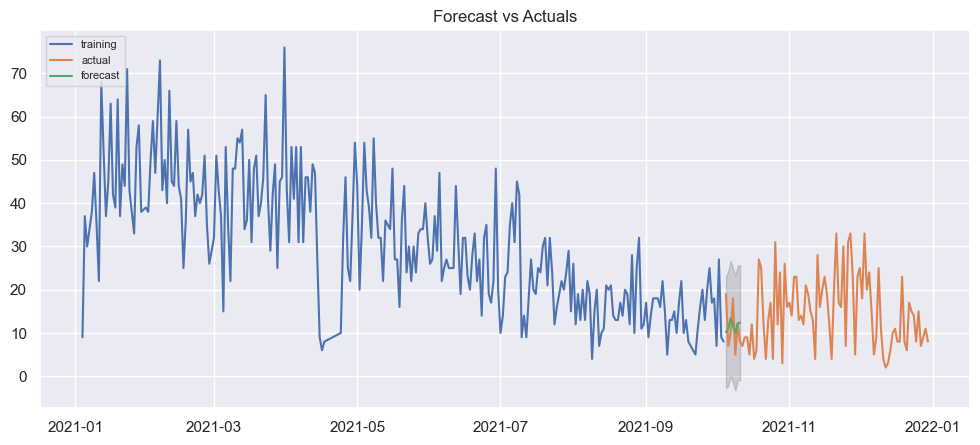

In [18]:
# Checking the performance of ARIMA(2, 1, 4) on a pair (training_set, test_set)

train = ts[:264]
test = ts[264:]

h = 7 # forecast horizon

model = ARIMA(np.array([float(x) for x in train.values]), order=(2, 1, 4))
fitted = model.fit(disp=-2)

fc, se, conf = fitted.forecast(h, alpha=0.2)

fc_series = pd.Series(fc, index=test.index[:h])
lower_series = pd.Series(conf[:, 0], test.index[:h])
upper_series = pd.Series(conf[:, 1], test.index[:h])

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)

### On the plot above the fitting seems good

In [19]:
# Model selection by MAE score and cross-validation with test_set_size=7

mae_scores = {}

for p, q in [(i, j) for i in range(0, 5) for j in range(0, 7)]:
    flag = 0
    mae = []
    for i in range(264, 348, 7):
            tr = ts[ : i]
            tts = ts[i : i+h]
            model = ARIMA(np.array([float(x) for x in tr.values]), order=(p, 1, q))
            try:
                fitted = model.fit(disp=-2)
            except:
                flag = 1
                pass
            fc = fitted.forecast(h, alpha=0.2)[0]
            mae.append(np.mean(np.abs(fc - [float(x) for x in tts.values])))
            if flag == 1:
                pass
    mae = np.mean(mae)
    mae_scores[(p, q)] = mae

/Users/yuni/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/yuni/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/yuni/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/yuni/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/yuni/opt/anaconda3/lib/python3.9/site-packages/statsmodels/ba

In [20]:
mae_scores

{(0, 0): 8.189552066097693,
 (0, 1): 6.771832877391126,
 (0, 2): 7.198162629133134,
 (0, 3): 7.2827627971101565,
 (0, 4): 7.242202746384681,
 (0, 5): 7.5448509552231435,
 (0, 6): 7.66877964420696,
 (1, 0): 7.599346992648862,
 (1, 1): 7.576704435604525,
 (1, 2): 7.463203492814867,
 (1, 3): 7.341892060432197,
 (1, 4): 7.221864067719605,
 (1, 5): 7.665854316086448,
 (1, 6): 7.06215563459594,
 (2, 0): 6.822115386048828,
 (2, 1): 7.280891471215457,
 (2, 2): 7.298472624058643,
 (2, 3): 6.965012613282575,
 (2, 4): 6.915868251055572,
 (2, 5): 7.600915366749821,
 (2, 6): 7.632256136404188,
 (3, 0): 6.777462010168979,
 (3, 1): 7.41901397540049,
 (3, 2): 7.467871928059945,
 (3, 3): 7.038271180524556,
 (3, 4): 7.21613436515857,
 (3, 5): 7.115066510389422,
 (3, 6): 7.5701516943172535,
 (4, 0): 6.83910116088753,
 (4, 1): 7.518679020609421,
 (4, 2): 7.429252290330044,
 (4, 3): 7.745017833266548,
 (4, 4): 7.75166202874744,
 (4, 5): 7.583929951812657,
 (4, 6): 7.410662081453341}

### Frome the mae_scores we see that there are several models with MAE < 7. We choose them as base models for stacking

In [21]:
# Obtaining the best models

base_models = [(p, 1, q) for p, q in mae_scores.keys() if mae_scores[(p, q)] < 7] 

In [23]:
# Getting their forecasts

extended_time = pd.DatetimeIndex(((ts.index + pd.Timedelta(7, 'D')).values[-7:])).to_period('D')
forecasts = {}
lower = {}
upper = {}
ses = {}

for order in base_models:
    model = ARIMA(ts_training, order=order)
    fitted_model = model.fit(disp=-2)
    forecast, se, confi = fitted_model.forecast(7, alpha=0.2)
    key = f'ARIMA({order})'
    forecasts[key] = forecast
    lower[key] = confi[:, 0]
    upper[key] = confi[:, 1]
    ses[key] = se
    forecast = pd.Series(forecast, index=extended_time)
    lower_limit = pd.Series(confi[:, 0], index=extended_time)
    upper_limit = pd.Series(confi[:, 1], index=extended_time)

/Users/yuni/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/yuni/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/yuni/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/yuni/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A dat

### Then we perform Holt's exponential smoothning 

In [24]:
model = ExponentialSmoothing(ts_training, initialization_method="heuristic", trend='additive')
fitted_model = model.fit()
forecast = fitted_model.forecast(7)

forecasts['Exp_sm'] = forecast.values

/Users/yuni/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/yuni/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


### Next we stack the base models and obtain the final result

In [25]:
forecasts = np.around(pd.DataFrame(forecasts).mean(axis=1), 0).values
lower = np.around(pd.DataFrame(lower).mean(axis=1), 0).values
upper = np.around(pd.DataFrame(upper).mean(axis=1), 0).values
ses = np.around(pd.DataFrame(ses).mean(axis=1), 0).values

In [26]:
for n in range(0, 7):
    print(f'В день {extended_time.values[n]} ожидается продажа {forecasts[n]} +- {ses[n]} единиц')

В день 2021-12-31 ожидается продажа 9.0 +- 10.0 единиц
В день 2022-01-01 ожидается продажа 10.0 +- 11.0 единиц
В день 2022-01-02 ожидается продажа 10.0 +- 11.0 единиц
В день 2022-01-03 ожидается продажа 9.0 +- 11.0 единиц
В день 2022-01-04 ожидается продажа 9.0 +- 12.0 единиц
В день 2022-01-05 ожидается продажа 9.0 +- 12.0 единиц
В день 2022-01-06 ожидается продажа 9.0 +- 13.0 единиц


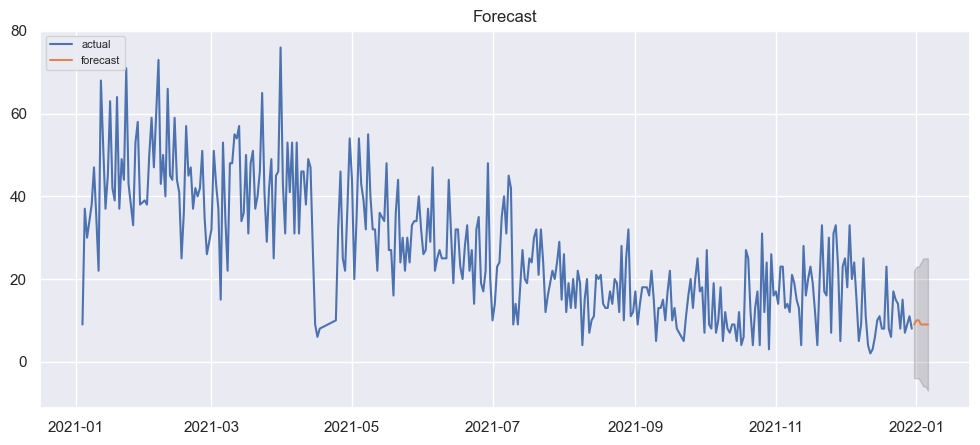

In [27]:
# Plotting the forecast and the corresponding 80%-confidence interval

forecasts = pd.Series(forecasts, index=extended_time)
lower = pd.Series(lower, index=extended_time)
upper = pd.Series(upper, index=extended_time)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(ts, label='actual')
plt.plot(forecasts, label='forecast')
plt.fill_between(lower.index, lower, upper, 
                 color='k', alpha=.15)
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)

In [36]:
# CSV file

result = forecasts.to_frame().reset_index().rename(columns={'index':'dates', 0:'quantities'})
result['se'] = ses
result.to_csv('/Users/yuni/Downloads/test.csv')